# Topic Modelling US Supreme Court Cases with High Performance Python
Written paper to follow

__Credits__<br>
Case Law Access Project: https://case.law/ <br>
Gensim Library: https://radimrehurek.com/gensim/index.html <br>
Abhijeet Kumar: https://github.com/abhijeet3922/Topic-Modelling-on-Wiki-corpus <br>
Susan Li: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [ ]:
# System and file libraries
import os, sys, random, codecs
import pickle, datetime, logging

# Profiling libraries
import memory_profiler, line_profiler

# Data parsing and wrangling libraries
import lzma, json
from pathlib import Path 
import xml.etree.cElementTree as ET
import pandas as pd
import numpy as np

# Multiprocessor
import concurrent.futures

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# User defined class and methods
from casewrangler import CaseWrangler
from topicmodel import TopicModel

# Modelling library
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

## __1)__ __Case Wrangling__

In [6]:
# Setting case wrangling class to CW
cw = CaseWrangler()

## (a) Speeding Up the Case Wrangler

### (i) Extract Cases

#### __Single Processing for Multiple States__

In [69]:
file_paths = os.listdir(path = 'Cases/')
files = ['Cases/' + path + '/data/data.jsonl.xz' for path in file_paths]

# Removing ipynb checkpoints from files
del files[0]

if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    c = cw.extractCases(files)
    
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)

# Total Time Elapsed: 0:01:58.719457

#### __Profiling the Function__

Results below show that extraction takes approximately 0.0003 seconds per case

__Arizona__<br>
Number of Cases: 28182<br>
Total Time Elapsed: 0:00:10.384741

__Illinois__<br>
Number of Cases: 183149<br>
Total Time Elapsed: 0:01:03.854829

__Line Profiler Results__ 

In [ ]:
%reload_ext line_profiler
%lprun -f cw.extractCases cw.extractCases(files[0])

__Memory Profiler Results__

In [ ]:
%reload_ext memory_profiler
%mprun -f cw.extractCases cw.extractCases(files[0])

In [ ]:
%reload_ext memory_profiler
%memit cw.extractCases(files[0])

#### __Multiprocessing for Multiple States__

In [ ]:
# Note that approach of assigning each zip file as a task takes up too much memory so it stalls the process
# So changed to a computer with more RAM space

def extractMulti():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        cases = executor.map(cw.extractCases, files)
        
    return cases

if __name__ == "__main__":
    start=datetime.datetime.now()
    
    extractMulti()
    
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)
    
# Total Time Elapsed Chunksize=1: 0:02:41.332746
# Total Time Elapsed Chunksize=2: 0:03:43.614178
# Total Time Elapsed Chunksize=10: 0:05:01.03791
# Total Time Elapsed Chunksize=10,000: 0:05:01.855583

In [ ]:
%reload_ext memory_profiler
%memit extractMulti()

## (ii) Wrangle Cases into DataFrame

#### __Single Processing of Wrangling Using Arizona__

In [ ]:
az_path = os.path.abspath('Arizona-20181204-xml/data/data.jsonl.xz')
az_corpus = os.path.abspath('Arizona-20181204-xml/corpus')
az_cases = cw.extractCases(az_path)

if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    az_df = cw.wrangleCases(az_cases)
        
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)

# Total Time Elapsed: 0:00:10.312315

#### __Profiling the Function__

Results below show that wrangling takes approximately 0.0003 seconds per case

__Arizona__<br>
Number of Cases: 28182<br>
Total Time Elapsed: 0:00:11.417168

__Line Profiler Results__

In [ ]:
%reload_ext line_profiler
%lprun -f cw.wrangleCases cw.wrangleCases(az_cases)

__Memory Profiler Results__

In [ ]:
# Memory used is contant throughout as most of it comes from loading the cases, as such only memit is shown below
%reload_ext memory_profiler
%memit cw.wrangleCases(az_cases)

#### __Multiprocessing of Wrangling Using Arizona__

In [ ]:
# Multiprocessing of Wrangling Using Arizona
# Optimal workers and chunksize used below
def multiWrangle():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(cw.wrangleCases, az_cases, chunksize = 16)
    
    return results

if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    multiWrangle = multiWrangle()
        
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)
    
# Total Time Elapsed: 0:00:01.829192

In [4]:
# Using a loop I ran the multiprocessing with varying workers and chunksizes
# Theses were saved onto a file loaded below

# Importing saved runtimes for optimised processes
xlsx = pd.ExcelFile('DAS Times.xlsx')

data_c1 = pd.read_excel(xlsx, 0)
data_w1 = pd.read_excel(xlsx, 1)
data_w4 = pd.read_excel(xlsx, 2)
data_c2 = pd.read_excel(xlsx, 3)
data_w8 = pd.read_excel(xlsx, 4)

__Results for Workers Optimisation__

<function matplotlib.pyplot.show(*args, **kw)>

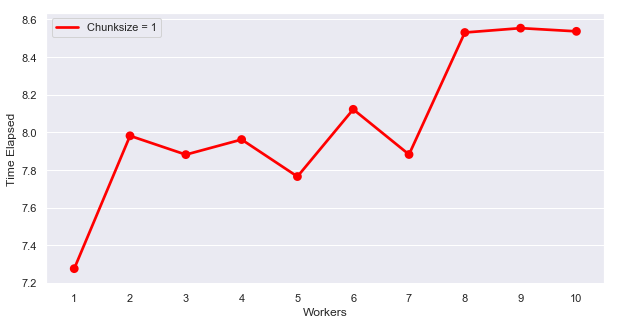

In [8]:
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize = (10, 5))

sns.pointplot(ax=ax,x='Workers',y='Time Elapsed',data=data_c1,color='red')

ax.legend(handles=ax.lines[::len(data_c1)+1], labels=['Chunksize = 1'])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])

plt.show

__Results for Workers Optimisation__

<function matplotlib.pyplot.show(*args, **kw)>

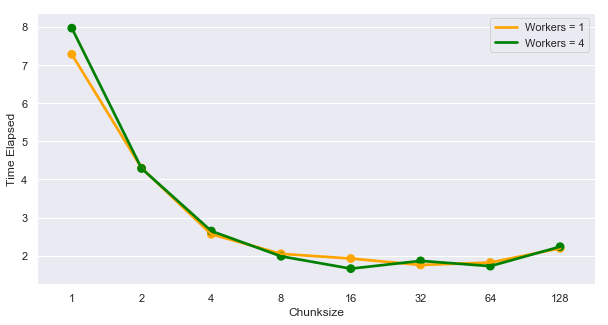

In [9]:
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize = (10, 5))

sns.pointplot(ax=ax,x='Chunksize',y='Time Elapsed',data=data_w1,color='orange')
sns.pointplot(ax=ax,x='Chunksize',y='Time Elapsed',data=data_w4,color='green')

ax.legend(handles=ax.lines[::len(data_w1)+1], labels=['Workers = 1','Workers = 4'])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])

plt.show

## __2)__ __Topic Modelling__

In [8]:
# Setting topic model class to TM
tm = TopicModel()

## Speeding Up Topic Modelling

### (i) Creating Corpus 

#### __Single Processing of Corpus Creation Using Arizona__

In [9]:
# Data Preprocessing for Modelling Using Arizona 
if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    docs = tm.createCorpus(az_corpus, az_df)

    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)

# Total Time Elapsed: 0:00:14.324246

Total Time Elapsed: 0:01:04.610561


#### __Profiling the Function__

Results below show the loop takes the bulk of time.<br>
We get an average time of 0.0005 per case opinion created

__Line Profiler Results__

In [ ]:
%reload_ext line_profiler
%lprun -f tm.createCorpus tm.createCorpus(az_corpus, az_df)

__Memory Profiler Results__

In [ ]:
# Memory used is contant throughout as most of it comes from loading the cases, as such only memit is shown below
%reload_ext memory_profiler
%memit tm.createCorpus(az_corpus, az_df)

#### __Multiprocessing of Corpus Creation Using Arizona__

In [ ]:
# Creating corpus using multiprocessing optimisation
# Optimal workers and chunksize used below

def multiCorpus():

    with concurrent.futures.ProcessPoolExecutor(max_workers = 4) as executor:
        result = executor.map(createCorpus(corpus_path, df), chunksize = 256) 
    
    return result

if __name__ == "__main__":
    start=datetime.datetime.now() 

    multiCorpus()
        
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)
    
# Total Time Elapsed: 0:00:11.437879

__Results for Workers Optimisation__

<function matplotlib.pyplot.show(*args, **kw)>

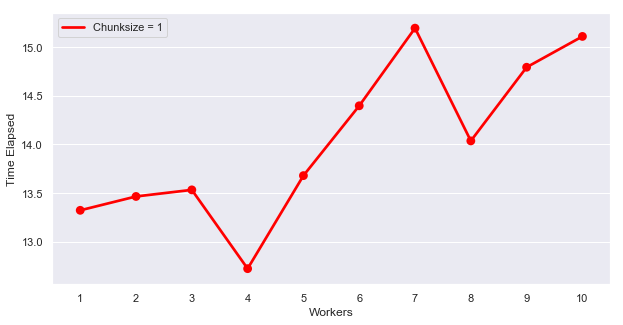

In [11]:
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize = (10, 5))

sns.pointplot(ax=ax,x='Workers',y='Time Elapsed',data=data_c2,color='red')

ax.legend(handles=ax.lines[::len(data_c2)+1], labels=['Chunksize = 1'])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])

plt.show

__Results for Chunksize Optimisation__

<function matplotlib.pyplot.show(*args, **kw)>

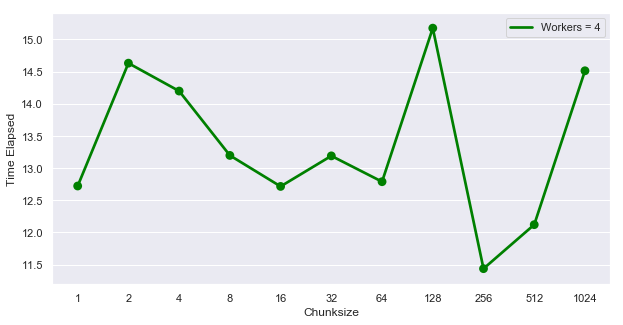

In [13]:
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize = (10, 5))

sns.pointplot(ax=ax,x='Chunksize',y='Time Elapsed',data=data_w8,color='green')

ax.legend(handles=ax.lines[::len(data_w8)+1], labels=['Workers = 4'])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])

plt.show

### (ii) Final Data Preprocessing

#### __Single Processing of Preprocessing Using Arizona__

In [ ]:
# Data Preprocessing for Modelling Using Arizona
# Preparing data to go into LDA model

def preProcess():

    docs_clean = [tm.cleanWords(doc) for doc in docs] 
    dict_clean = tm.filterWords(docs_clean) 
    term_matrix = [dict_clean.doc2bow(doc) for doc in docs_clean]
    
    return docs_clean, dict_clean, term_matrix

if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    model_inputs = preProcess()
    
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)

# Total Time Elapsed: 0:03:06.558201

#### __Profiling the Function__

As functions from the gensim and NLTK library are used it is not possible to use line profiler<br>
Memory profiling is shown below as this is a key bottleneck encountered.

Average time per case comes to 0.008 seconds

__Memory Profiler Results__

In [ ]:
%reload_ext memory_profiler
%memit preProcess()

#### __Multiprocessing of Model Preprocessing Using Arizona__

In [18]:
# Data Preprocessing for Modelling Using Arizona
# Multiprocessing of preprocessing

def preProcessMulti():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        inputs_multi = executor.map(preProcess())
    
    return inputs_multi

if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    model_inputs_multi = preProcessMulti()
    
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)

# Total Time Elapsed Chunksize=1: 0:03:10.989401
# Total Time Elapsed Chunksize=2: 0:03:12.271223
# Total Time Elapsed Chunksize=5: 0:03:11.716095
# Total Time Elapsed Chunksize=10: 0:03:13.317744
# Total Time Elapsed Chunksize=100: 0:03:15.717454
# Total Time Elapsed Chunksize=1000: 0:03:13.301354

In [ ]:
%reload_ext memory_profiler
%memit preProcessMulti()

### (iii) LDA Modelling

#### __Single Processing of LDA Using Arizona__

In [ ]:
# Single processing of LDA
def singlLDA():
    lda = LdaModel(corpus=term_matrix, id2word=dict_clean)
    
    return lda
    
if __name__ == "__main__":
    start=datetime.datetime.now()
    
    singlLDA = singlLDA()

    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)
    
# Total Time Elapsed: 0:05:38.095177
# Total Time Elapsed: 0:04:56.425165

#### __Profiling the Function__

Could not use line profiler on the LDA as we could not extract the object from gensim <br>
%reload_ext line_profiler <br>
%lprun -f LdaModel LdaModel(corpus=term_matrix, id2word=dict_clean)

In [ ]:
%reload_ext memory_profiler
%memit LdaModel(corpus=term_matrix, id2word=dict_clean)

#### __Multiprocessing of LDA Using Arizona__

__ProcessPoolExecutor__

In [ ]:
# Multiprocessing of LDA using ProcessPoolExecutor

def multiLDA():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        lda = executor.map(LdaModel(corpus=term_matrix, id2word=dict_clean), chunksize=6000)
    
    return lda

if __name__ == "__main__":
    start=datetime.datetime.now() 
    
    multiLDA = multiLDA()
        
    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)
    
# Total Time Elapsed Chunksize=1: 0:04:43.841308
# Total Time Elapsed Chunksize=6000: 0:03:40.858797

In [ ]:
%reload_ext memory_profiler
%memit multiLDA()

__Gensim__

In [ ]:
# Multiprocessing of LDA using gensim multicore
def multiLDAGen():
    lda = LdaMulticore(corpus=term_matrix, id2word=dict_clean)
    
    return lda

if __name__ == "__main__":
    start=datetime.datetime.now()
    
    multiLDAGen = multiLDAGen()

    time=datetime.datetime.now()-start
    print('Total Time Elapsed:', time)
    
# Total Time Elapsed 3/4000: 0:02:50.236988

#### __Distributing Computing Optimisation of LDA Using Arizona__ 

In [ ]:
# Distributed LDA (Ran on terminal and server)

#For each computer in the cluster, run the following in the command line
$ sudo easy_install gensim[distributed]
$ export PYRO_SERIALIZERS_ACCEPTED=pickle
$ export PYRO_SERIALIZER=pickle

# Run Pyro name server on one of the machines
$ python -m Pyro4.naming -n 0.0.0.0 &

#Select the workers in the cluster and assign them in the command line using the code below
$ python -m gensim.models.lda_worker &

#Select the dispatcher and assign it in the command line using the code below
$ python -m gensim.models.lda_dispatcher &

#Now our cluster is set up and running, ready to accept jobs.
#We can now run the LDA in the command line of the dispatcher and indicate that we there are clusters available
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

lda = LdaModel(corpus=term_matrix, id2word=dict_clean, distributed=True)
    
# Total Time Elapsed 3/Home: 0:05:17.745186
# Total Time Elapsed 3/Server:0:19:03.821357
# Total Time Elapsed 6/Server:0:14:03.821357

#### __LDA Model Results__

__(a) Check Topics__

In [ ]:
# Print LDA topics with weights 
for topic in singlLDA.print_topics(num_topics=5, num_words=10):
    print (topic[0]+1, " ", topic[1],"\n")

# # Print LDA topics formatted without weights 
# for idx, topic in singlLDA.show_topics(formatted=False, num_words= 10):
#     print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

In [ ]:
for topic in multiLDAGen.print_topics(num_topics=5, num_words=10):
    print (topic[0]+1, " ", topic[1],"\n")

__(b) Visualise Topics__

In [ ]:
# pyLDAvis visualisation of model to see salient terms
lda_display = pyLDAvis.gensim.prepare(singlLDA, term_matrix, dict_clean, sort_topics=True)
pyLDAvis.save_html(lda_display, 'ldaSingl.html')
pyLDAvis.display(lda_display)

In [ ]:
lda_display = pyLDAvis.gensim.prepare(multiLDAGen, term_matrix, dict_clean, sort_topics=True)
pyLDAvis.save_html(lda_display, 'ldaMulti.html')
pyLDAvis.display(lda_display)